<a href="https://colab.research.google.com/github/Alfred9/Exploring-LLMs/blob/main/Visual%20Language%20Models/Vision_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install  Required Packages
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

!pip install git+https://github.com/huggingface/transformers.git@60bb571e993b7d73257fb64044726b569fef9403 pillow==10.3.0 chardet==5.2.0 flash_attn==2.5.8 accelerate==0.30.1 bitsandbytes==0.43.1


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Cloning https://github.com/huggingface/transformers.git (to revision 60bb571e993b7d73257fb64044726b569fef9403) to /tmp/pip-req-build-mwyar4mg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-mwyar4mg
  Running command git rev-parse -q --verify 'sha^60bb571e993b7d73257fb64044726b569fef9403'
  Running command git fetch -q https://github.com/huggingface/transformers.git 60bb571e993b7d73257fb64044726b569fef9403
  Running command git checkout -q 60bb571e993b7d73257fb64044726b569fef9403
  Resolved https://github.com/huggingface/transformers.git to commit 60bb571e993b7d73257fb64044726b569fef9403
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch

In [3]:
#Define Model ID
model_id ="Microsoft/Phi-3-vision-128k-instruct"

In [4]:
# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

preprocessor_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

processing_phi3_v.py:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

image_processing_phi3_v.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Microsoft/Phi-3-vision-128k-instruct:
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/Microsoft/Phi-3-vision-128k-instruct:
- processing_phi3_v.py
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
#Load model with 4-bit quaninization an map to CUDA

model=AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
    _attn_implementation='eager'

)

config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

configuration_phi3_v.py:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Microsoft/Phi-3-vision-128k-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3_v.py:   0%|          | 0.00/75.4k [00:00<?, ?B/s]

image_embedding_phi3_v.py:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Microsoft/Phi-3-vision-128k-instruct:
- image_embedding_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/Microsoft/Phi-3-vision-128k-instruct:
- modeling_phi3_v.py
- image_embedding_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/68.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Define initial chat message with image placeholder
messages = [{"role": "user", "content": "<|image_1|>\nWhat is shown in this image?"}]

# Download image from URL
url = "https://media.hswstatic.com/eyJidWNrZXQiOiJjb250ZW50Lmhzd3N0YXRpYy5jb20iLCJrZXkiOiJnaWZcL2JlY29taW5nLWRvY3Rvci5qcGciLCJlZGl0cyI6eyJyZXNpemUiOnsid2lkdGgiOjgyOH19fQ=="
image = Image.open(requests.get(url, stream=True).raw)

In [7]:
# Prepare prompt with image token
prompt = processor.tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process prompt and image for model input
inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

# Generate text response using model
generate_ids = model.generate(
    **inputs,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=500,
    do_sample=False,
)

# Remove input tokens from generated response
generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

# Decode generated IDs to text
response = processor.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]


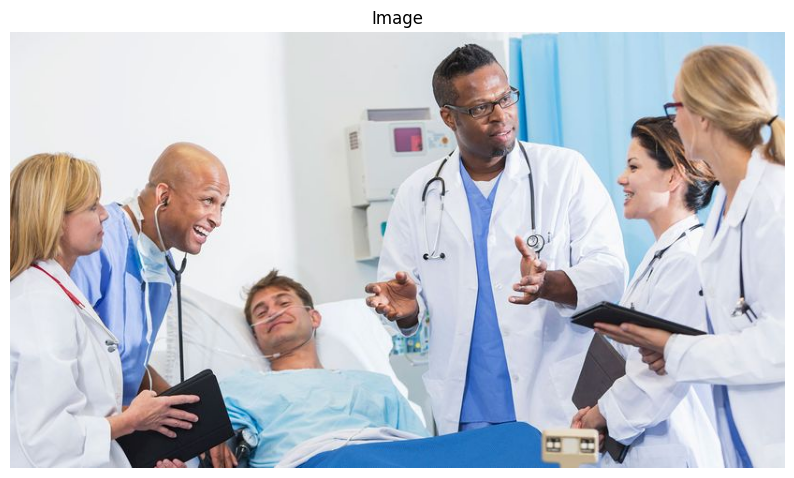

The image depicts a group of medical professionals, likely doctors and nurses, gathered around a patient lying in a hospital bed. They appear to be discussing the patient's condition or treatment plan.


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Image")
plt.axis('off')
plt.show()
print(response)

## Optical Character Recognition (OCR)

In [12]:
messages = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image as is. OCR:"}]
url = "https://i.postimg.cc/fRFvFVyv/Screenshot-from-2024-05-22-20-55-43.png"
image2 = Image.open(requests.get(url, stream=True).raw)

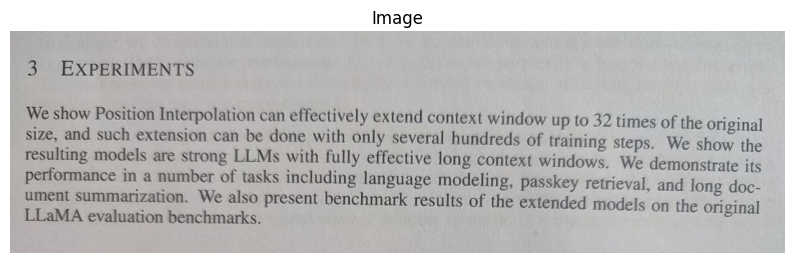

The image shows a text excerpt discussing the results of experiments related to position interpolation and the performance of resulting models.


In [16]:
# Process prompt and image for model input
inputs2 = processor(prompt, [image2], return_tensors="pt").to("cuda:0")

# Generate text response using model
generate_ids = model.generate(
    **inputs,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=500,
    do_sample=False,
)

# Remove input tokens from generated response
generate_ids2 = generate_ids[:, inputs2["input_ids"].shape[1] :]

# Decode generated IDs to text
response = processor.batch_decode(
    generate_ids2, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
plt.figure(figsize=(10, 10))
plt.imshow(image2)
plt.title("Image")
plt.axis('off')
plt.show()
print(response)